## Install Libraries


In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 14.6 MB/s eta 0:00:00


In [78]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer
import itertools
from torchvision import transforms

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import and Visualise Datasets

In [96]:
df_train = pd.read_json('/content/drive/MyDrive/DL_A4/hateful_memes/train.jsonl', lines = True)  #lines = true set for reading JSONL instead of json
df_train = df_train.loc[:, ['text', 'label']].rename(columns={'label': 'target'})

df_test = pd.read_json('/content/drive/MyDrive/DL_A4/hateful_memes/test_seen.jsonl', lines = True)
df_test = df_test.loc[:, ['text', 'label']].rename(columns={'label': 'target'})

df_val = pd.read_json('/content/drive/MyDrive/DL_A4/hateful_memes/dev_seen.jsonl', lines = True)
df_val = df_val.loc[:, ['text', 'label']].rename(columns={'label': 'target'})

df_train.head()

,text,target
0,its their character not their color that matters,0
1,don't be afraid to love again everyone is not ...,0
2,putting bows on your pet,0
3,i love everything and everybody! except for sq...,0
4,"everybody loves chocolate chip cookies, even h...",0


<Axes: xlabel='target'>

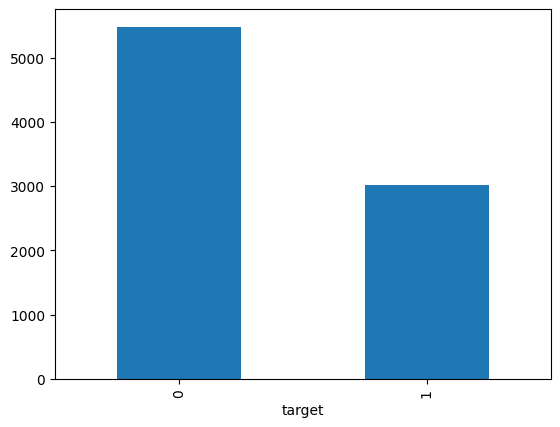

In [97]:
df_train.groupby(['target']).size().plot.bar()

## Modelling

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [93]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df['target'].to_list()
        self.texts = [tokenizer(str(text), 
                               padding='max_length', max_length = 64, truncation=True,
                                return_tensors="pt") for text in df['text']]
        # self.transform = transforms.Compose([transforms.ToTensor()])

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        # return batch_texts, batch_y
        # print(batch_texts.data, type(batch_texts.data), type(batch_texts))
        # print(batch_y)
        return batch_texts.data, batch_y.data

In [10]:
np.random.seed(112)
print(len(df_train),len(df_val), len(df_test))

8500 500 1000


In [52]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

## Training

In [12]:
#training 

from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):
    
    train_loss_list = []  #store metrics for every epoch in successsion for plotting graphs later
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    train, val = Dataset(train_data), Dataset(val_data) 

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0    #values calculated per epoch
        total_loss_train = 0
        total_acc_val = 0
        total_loss_val = 0

        num_batch_train = 0
        for train_input, train_label in tqdm(train_dataloader):
            
            num_batch_train += 1
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            #1 value per batch is given
            batch_loss = criterion(output, train_label.long())
            #sums up values whose count equal to the number of batches   
            total_loss_train += batch_loss.item()     
            
            # 1 value per sample is given , and at a time no.of values eql to batch size are computed and stored
            acc = (output.argmax(dim=1) == train_label).sum().item()  
            total_acc_train += acc     

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        train_loss_list.append(total_loss_train / num_batch_train)
        train_acc_list.append(total_acc_train / len(train_data))

        with torch.no_grad():
            num_batch_val = 0
            for val_input, val_label in val_dataloader:

                num_batch_val +=1
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())  
                total_loss_val += batch_loss.item()#  1 loss given per batch is summed
                
                
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc  #1 acc  score of matching given per sample is summed
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / num_batch_train: .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / num_batch_val: .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}')
        
        
        val_loss_list.append(total_loss_val / num_batch_val)
        val_acc_list.append(total_acc_val / len(val_data))

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 532/532 [01:37<00:00,  5.45it/s]


Epochs: 1 | Train Loss:  1.378             | Train Accuracy:  0.451             | Val Loss:  0.989             | Val Accuracy:  0.496


100%|██████████| 532/532 [01:38<00:00,  5.40it/s]


Epochs: 2 | Train Loss:  0.722             | Train Accuracy:  0.664             | Val Loss:  0.861             | Val Accuracy:  0.522


100%|██████████| 532/532 [01:38<00:00,  5.41it/s]


Epochs: 3 | Train Loss:  0.617             | Train Accuracy:  0.711             | Val Loss:  0.819             | Val Accuracy:  0.528


100%|██████████| 532/532 [01:40<00:00,  5.28it/s]


Epochs: 4 | Train Loss:  0.556             | Train Accuracy:  0.746             | Val Loss:  0.834             | Val Accuracy:  0.552


100%|██████████| 532/532 [01:40<00:00,  5.29it/s]


Epochs: 5 | Train Loss:  0.503             | Train Accuracy:  0.784             | Val Loss:  0.903             | Val Accuracy:  0.536


In [ ]:
# free CUDA memory
torch.cuda.empty_cache()

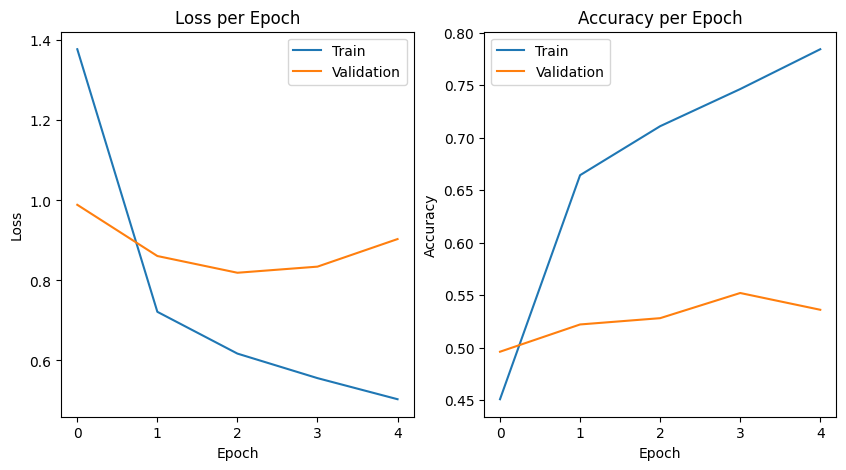

In [13]:
# plot the training statistics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# torch.save(model, '/content/drive/MyDrive/DL_A4/model_txt.pth')

In [108]:
model = torch.load('/content/drive/MyDrive/DL_A4/model_txt.pth').to(device)

## Testing

In [15]:
from sklearn.metrics import classification_report

def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    predicted_labels = []
    actual_labels = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            _, predictions = torch.max(output, 1)

            # acc = (predictions == test_label).sum().item()
            # total_acc_test += acc

            predictions = np.array([tensor.cpu().numpy() for tensor in predictions])
            test_labels = np.array([tensor.cpu().numpy() for tensor in test_label])

            predicted_labels.append(list(predictions))
            actual_labels.append(list(test_labels))

            
        predicted_labels = list(itertools.chain(*predicted_labels))
        actual_labels = list(itertools.chain(*actual_labels))
        print(classification_report(predicted_labels, actual_labels))
    
    # print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return predicted_labels, actual_labels
    
predicted_labels, actual_labels = evaluate(model, df_test)

              precision    recall  f1-score   support

           0       0.88      0.55      0.68       822
           1       0.24      0.66      0.35       178

    accuracy                           0.57      1000
   macro avg       0.56      0.61      0.51      1000
weighted avg       0.77      0.57      0.62      1000



## Inference

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def classify_text(text):
    # Tokenize the input text
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt').to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Perform the inference
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        prediction = output.argmax(dim = 1)

    # # Convert the output to a Python scalar and return it
    # prediction = prediction.detach().cpu().numpy().item()
    return prediction

# Example usage
text = "but you're on a diet when you have coke in the fridge"
prediction = classify_text(text)
value = 'hateful' if prediction == 1 else 'not-hateful'
print(f'Class Label =  {value}')

Class Label =  not-hateful


## Tsne- plots

In [27]:
df_test

,text,target
0,handjobs sold seperately,1
1,introducing fidget spinner for women,1
2,happy pride month let's go beat up lesbians,1
3,laughs in [majority of u.s crime rate],1
4,finds out those 72 virgins.. are goats,1
...,...,...
995,a mother's love for the child is a divine thing,0
996,sea monkeys,0
997,little miss muffet sat on her tuffet,0
998,they're in a row,0


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_hate = pd.DataFrame()
df_non_hate = pd.DataFrame()

for row in range(len(df_test)):
    if df_test['target'][row] == 1 and len(df_hate) < 50:
        df_hate = df_hate.append(df_test.loc[row], ignore_index = True)
        df_hate['target'] = df_hate['target'].apply(str)
    elif df_test['target'][row] == 0 and len(df_non_hate) < 50:
        df_non_hate = df_hate.append(df_test.loc[row], ignore_index = True)
        df_non_hate['target'] = df_non_hate['target'].apply(str)
    if len(df_hate) == 50 and len(df_non_hate) == 50:
        break

<ipython-input-45-958b75bd45fd>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hate = df_hate.append(df_test.loc[row], ignore_index = True)
<ipython-input-45-958b75bd45fd>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_non_hate = df_hate.append(df_test.loc[row], ignore_index = True)


In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for row in range(1):
        inputs = tokenizer.encode_plus(df_test['text'][row], padding='max_length', max_length = 64, add_special_tokens=True, return_tensors='pt').to(device)
        
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        print(input_ids)
        print(attention_mask)

        
        
        
        
        # text
        outputs = model(**inputs)





#  # Tokenize the input text
#     inputs = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt').to(device)
#     input_ids = inputs['input_ids']
#     attention_mask = inputs['attention_mask']

#     # Perform the inference
#     with torch.no_grad():
#         output = model(input_ids, attention_mask)
#         prediction = output.argmax(dim = 1)


tensor([[  101,  2192,  5558,  5910,  2853, 19802, 22139,  2135,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]], device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


TypeError: ignored

In [100]:
type(df_test['text'][1])

str

In [92]:
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.manifold import TSNE

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertClassifier()
model = torch.load('/content/drive/MyDrive/DL_A4/model_txt.pth')


# encoded_input_hate = tokenizer(df_hate['text'], padding='max_length', max_length = 64, truncation=True, return_tensors='pt')
# encoded_input_non_hate = tokenizer(df_non_hate['text'], padding='max_length', max_length = 64, truncation=True, return_tensors='pt')

encoded_input_hate = Dataset(df_hate)
encoded_input_non_hate = Dataset(df_non_hate)

hate_dataloader = torch.utils.data.DataLoader(encoded_input_hate, batch_size=50)
hateless_dataloader = torch.utils.data.DataLoader(encoded_input_non_hate, batch_size=50)



with torch.no_grad():
     for hate_input, hate_label in hate_dataloader:
            hate_label = hate_label.to(device)
            mask = hate_input['attention_mask'].to(device)
            input_id = hate_input['input_ids'].squeeze(1).to(device)

            output_hate = model(input_id, mask)


# # Get the embeddings from the last hidden layer
# last_hidden_state_hate = model_output_hate.last_hidden_state.cpu().numpy()
# last_hidden_state_non_hate = model_output_hate.last_hidden_state.cpu().numpy()

# # Use t-SNE to reduce dimensionality to 2D
# tsne = TSNE(n_components=2, random_state=42)
# embeddings_2d_hate = tsne.fit_transform(last_hidden_state_hate)
# embeddings_2d_non_hate = tsne.fit_transform(last_hidden_state_non_hate)

# # Plot the embeddings in a scatter plot
# plt.scatter(embeddings_2d_hate[:,0], embeddings_2d_non_hate[:,1])
# plt.show()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


NotImplementedError: ignored